In [1]:
# Importing all the necessary modules

import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
import time
import matplotlib.pyplot as plt
import math
import datetime
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model
import imutils
# from guidedfilter import guided_filter

In [2]:
# Paths to various folders and files

path = '/Users/rohitramesh4547gmail.com/Desktop/IITG/Semester-7/BTP/Good_Illumination_Images'
store_path = '/Users/rohitramesh4547gmail.com/Desktop/IITG/Semester-7/BTP/Darkened_Images_0.2'
fold_path = '/Users/rohitramesh4547gmail.com/Desktop/IITG/Semester-7/BTP'
enhanced_path = '/Users/rohitramesh4547gmail.com/Desktop/IITG/Semester-7/BTP/Enhanced_Images_Histogram_Equalization'
test_path = fold_path + '/test_dark.jpeg'
path = '/content/drive/MyDrive/Illumination_Enhancement_BTP/Good_Illumination_Images'
store_path_1 = '/content/drive/MyDrive/Illumination_Enhancement_BTP/Darkened_Images_0.1'
store_path_2 = '/content/drive/MyDrive/Illumination_Enhancement_BTP/Darkened_Images_0.2'
store_path_3 = '/content/drive/MyDrive/Illumination_Enhancement_BTP/Darkened_Images_0.3'
rain_path = '/content/drive/MyDrive/Illumination_Enhancement_BTP/Rain_Images'
snow_path = '/content/drive/MyDrive/Illumination_Enhancement_BTP/Snow_Images'

In [3]:
# For Google Colab Only!

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Loading Image for testing and converting it to gray-scale for the Medium Article Methods
test_image = cv2.imread(store_path_1 + '/darkened_IMG_2821.jpeg')
gray_img = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
original_image = cv2.imread(path + '/IMG_2821.jpeg')

In [ ]:
# Saved in Darkened_Images_0.1

for file_name in os.listdir(path):
    try:
        img = Image.open(path + '/' + file_name)
        enhancer = ImageEnhance.Brightness(img)

        factor = 0.1
        im_output = enhancer.enhance(factor)
        im_output.save(store_path_1 + '/darkened_' + file_name)
    except Exception as e:
        print(e)

In [ ]:
# Function defined to Calculate Mean Squared Error 

def mse(result, truth):
    sum_of_squares = 0
    for i in range(truth.shape[0]):
        for j in range(truth.shape[1]):
            for k in range(truth.shape[2]):
                sum_of_squares += pow(truth[i][j][k] - result[i][j][k], 2)
    return (sum_of_squares / (truth.shape[0] * truth.shape[1] * truth.shape[2]))

In [ ]:
def get_illumination_channel(I, w):
    M, N, _ = I.shape
    padded = np.pad(I, ((int(w/2), int(w/2)), (int(w/2), int(w/2)), (0, 0)), 'edge')
    darkch = np.zeros((M, N))
    brightch = np.zeros((M, N))
    for i, j in np.ndindex(darkch.shape):
        darkch[i, j] = np.min(padded[i:i + w, j:j + w, :]) # dark channel
        brightch[i, j] = np.max(padded[i:i + w, j:j + w, :]) # bright channel
    return darkch, brightch

In [ ]:
darkch, brightch = get_illumination_channel(test_image, 5)
# darkch = Image.fromarray(darkch)
# brightch = Image.fromarray(brightch)
# brightch.show()

In [ ]:
def get_atmosphere(I, brightch, p=0.1):
    M, N = brightch.shape
    flatI = I.reshape(M*N, 3) # reshaping image array
    flatbright = brightch.ravel() #flattening image array
    searchidx = (-flatbright).argsort()[:int(M*N*p)] # sorting and slicing
    A = np.mean(flatI.take(searchidx, axis=0), dtype=np.float64, axis=0)
    return A

In [ ]:
A = get_atmosphere(test_image, brightch)

In [ ]:
def get_initial_transmission(A, brightch):
    A_c = np.max(A)
    init_t = (brightch-A_c)/(1.-A_c) # finding initial transmission map
    return (init_t - np.min(init_t))/(np.max(init_t) - np.min(init_t)) # normalized initial transmission map

In [ ]:
init_map = get_initial_transmission(A, brightch)

In [ ]:
def get_corrected_transmission(I, A, darkch, brightch, init_t, alpha, omega, w):
    im = np.empty(I.shape, I.dtype);
    for ind in range(0, 3):
        im[:, :, ind] = I[:, :, ind] / A[ind] #divide pixel values by atmospheric light
    dark_c, _ = get_illumination_channel(im, w) # dark channel transmission map
    dark_t = 1 - omega*dark_c # corrected dark transmission map
    corrected_t = init_t # initializing corrected transmission map with initial transmission map
    diffch = brightch - darkch # difference between transmission maps
    for i in range(diffch.shape[0]):
        for j in range(diffch.shape[1]):
            if(diffch[i, j] < alpha):
                corrected_t[i, j] = dark_t[i, j] * init_t[i, j]
    return np.abs(corrected_t)

In [ ]:
corrected_map = get_corrected_transmission(test_image, A, darkch, brightch, init_map, 0.4, 0.75, 5)
# corrected_map = Image.fromarray(corrected_map)
# corrected_map.show()

In [ ]:
def get_final_image(I, A, refined_t, tmin):
    refined_t_broadcasted = np.broadcast_to(refined_t[:, :, None], (refined_t.shape[0], refined_t.shape[1], 3)) # duplicating the channel of 2D refined map to 3 channels
    J = (I-A) / (np.where(refined_t_broadcasted < tmin, tmin, refined_t_broadcasted)) + A # finding result 

    return (J - np.min(J))/(np.max(J) - np.min(J)) # normalized image

In [ ]:
final = get_final_image(test_image, A, corrected_map, 0.1)
final = (final*255).astype(np.uint8)
# final_img = Image.fromarray(final)
# final_img.show()

In [ ]:
def reduce_init_t(init_t):
    init_t = (init_t*255).astype(np.uint8) 
    xp = [0, 32, 255]
    fp = [0, 32, 48]
    x = np.arange(256) # creating array [0,...,255]
    table = np.interp(x, xp, fp).astype('uint8') # interpreting fp according to xp in range of x
    init_t = cv2.LUT(init_t, table) # lookup table
    init_t = init_t.astype(np.float64)/255 # normalizing the transmission map
    return init_t

In [ ]:
def dehaze(im, tmin=0.1, w=5, alpha=0.4, omega=0.75, p=0.1, eps=1e-3, reduce=False):
    I = np.asarray(im, dtype=np.float64) # Convert the input to a float array.
    I = I[:, :, :3] / 255
    m, n, _ = I.shape
    Idark, Ibright = get_illumination_channel(I, w)
#     print("Obtained bright and dark channel priors")
#     Image.fromarray(Idark).save(fold_path + '/dark_channel_prior.png')
#     Image.fromarray(Ibright).save(fold_path + '/bright_channel_prior.jpg')
    A = get_atmosphere(I, Ibright, p)
#     print("Obtained atmosphere lighting")
#     Image.fromarray(A).save(fold_path + '/atmosphere.jpg')
    init_t = get_initial_transmission(A, Ibright) 
#     print("Obtained initial transmission map")
#     Image.fromarray(init_t).save(fold_path + '/init_transmission.jpg')
    if reduce:
        init_t = reduce_init_t(init_t)
#         print("Obtained reduced transmission map")
#         Image.fromarray(init_t).save(fold_path + '/reduced_transmission.jpg')
    corrected_t = get_corrected_transmission(I, A, Idark, Ibright, init_t, alpha, omega, w)
#     print("Obtained corrected transmission map")
#     Image.fromarray(corrected_t).save(fold_path + '/corrected_transmission.jpg')

    normI = (I - I.min()) / (I.max() - I.min())
    refined_t = guided_filter(normI, corrected_t, w, eps) # applying guided filter
#     print("Obtained image after applying guided filter")
#     Image.fromarray(refined_t).save(fold_path + '/guided_filter.jpg')
    
    J_refined = get_final_image(I, A, refined_t, tmin)
#     print("Obtained final image before enhancement")
#     Image.fromarray(J_refined).save(fold_path + '/J_refined_before_enhancement.jpg')
    
    enhanced = (J_refined * 255).astype(np.uint8)
    f_enhanced = cv2.detailEnhance(enhanced, sigma_s=10, sigma_r=0.15)
    f_enhanced = cv2.edgePreservingFilter(f_enhanced, flags=1, sigma_s=64, sigma_r=0.2)
    return f_enhanced

In [ ]:
# Stack Exchange Solution (Increasing value in HSV image)
def increase_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[:, :, 2] += value
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

stack_bright = increase_brightness(test_image, 50)
# stack_bright = Image.fromarray(stack_bright)
# stack_bright.show()

In [ ]:
# OpenCV method using (alpha * pixel + beta) ^ gamma method
def increase_contrast_brightness(img, alpha, beta, gamma):
    new_image = np.zeros(img.shape, img.dtype)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            for c in range(img.shape[2]):
                new_image[y, x, c] = np.clip(alpha * img[y, x, c] + beta, 0, 255)
    lookUpTable = np.empty((1, 256), np.uint8)
    for i in range(256):
        lookUpTable[0, i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    res = cv2.LUT(new_image, lookUpTable)
    return new_image, res

image_linear_transform, gamma_corrected = increase_contrast_brightness(test_image, 2.2, 50, 0.4)
# gamma_corrected = Image.fromarray(gamma_corrected)
# gamma_corrected.show()

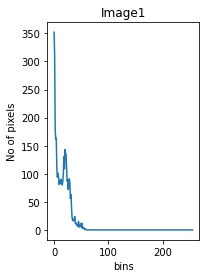

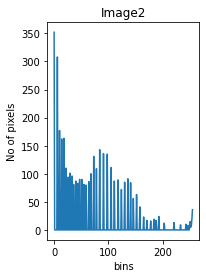

In [ ]:
# Using Histogram Equalization Method
hist = cv2.calcHist(gray_img, [0], None, [256], [0, 256])
plt.subplot(121)
plt.title("Image1")
plt.xlabel('bins')
plt.ylabel("No of pixels")
plt.plot(hist)
plt.show()
gray_img_eqhist = cv2.equalizeHist(gray_img)
hist = cv2.calcHist(gray_img_eqhist, [0], None, [256], [0, 256])
plt.subplot(121)
plt.title("Image2")
plt.xlabel('bins')
plt.ylabel("No of pixels")
plt.plot(hist)
plt.show()
# gray_img_eqhist = Image.fromarray(gray_img_eqhist)
# gray_img_eqhist.show()

In [ ]:
# Using CLAHE (Contrast Limited Adaptive Histogram Equalization)
gray_img_eqhist = cv2.equalizeHist(gray_img)
clahe = cv2.createCLAHE(clipLimit = 40)
gray_img_clahe = clahe.apply(gray_img_eqhist)
# gray_img_clahe = Image.fromarray(gray_img_clahe)
# gray_img_clahe.show()

In [ ]:
# OTSU Binarization 
ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# thresh = Image.fromarray(thresh)
# thresh.show()

# Adaptive Thresholding
thresh1 = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 31, 3)
thresh2 = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 5)
final = np.concatenate((thresh1, thresh2), axis = 1)
# final = Image.fromarray(final)
# final.show()

In [ ]:
# Test-Image
original_image = np.asarray(original_image, dtype=np.float64)
print(original_image.shape)

# Simple Pixel Enhancement
print(stack_bright.shape)
stack_bright = np.asarray(stack_bright, dtype=np.float64)
print("Simple Pixel Enhancement MSE = ", mse(stack_bright, original_image))

# Linear Pixel Transformation Method
print(image_linear_transform.shape)
image_linear_transform = np.asarray(image_linear_transform, dtype=np.float64)
print("Linear Pixel Transformation Method MSE = ", mse(image_linear_transform, original_image))

# Linear Pixel Transformation Method with Gamma Correction
print(gamma_corrected.shape)
gamma_corrected = np.asarray(gamma_corrected, dtype=np.float64)
print("Linear Pixel Transformation Method with Gamma Correction MSE = ", mse(gamma_corrected, original_image))

# Histogram Equalization Method
gray_img_eqhist = cv2.cvtColor(gray_img_eqhist, cv2.COLOR_GRAY2BGR)
print(gray_img_eqhist.shape)
gray_img_eqhist = np.asarray(gray_img_eqhist, dtype=np.float64)
print("Histogram Equalization Method = ", mse(gray_img_eqhist, original_image))

# CLAHE Method
gray_img_clahe = cv2.cvtColor(gray_img_clahe, cv2.COLOR_GRAY2BGR)
print(gray_img_clahe.shape)
gray_img_clahe = np.asarray(gray_img_clahe, dtype=np.float64)
print("CLAHE Method MSE = ", mse(gray_img_clahe, original_image))

# Adaptive Thresholding Method - MEAN
thresh1 = cv2.cvtColor(thresh1, cv2.COLOR_GRAY2BGR)
print(thresh1.shape)
thresh1 = np.asarray(thresh1, dtype=np.float64)
print("Adaptive Thresholding Method - MEAN MSE = ", mse(thresh1, original_image))

# Adaptive Thresholding Method - GAUSSIAN
thresh2 = cv2.cvtColor(thresh2, cv2.COLOR_GRAY2BGR)
print(thresh2.shape)
thresh2 = np.asarray(thresh2, dtype=np.float64)
print("Adaptive Thresholding Method - GAUSSIAN MSE = ", mse(thresh2, original_image))

# OTSU Binarization Method 
thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
print(thresh.shape)
thresh = np.asarray(thresh, dtype=np.float64)
print("OTSU Binarization Method  MSE = ", mse(thresh, original_image))

(3024, 4032, 3)
(3024, 4032, 3)
Simple Pixel Enhancement MSE =  5915.716875746891
(3024, 4032, 3)
Linear Pixel Transformation Method MSE =  2008.0117123527652
(3024, 4032, 3)
Linear Pixel Transformation Method with Gamma Correction MSE =  4416.644503200586
(3024, 4032, 3)
Histogram Equalization Method =  314.0960210730383
(3024, 4032, 3)
CLAHE Method MSE =  2928.990424433019
(3024, 4032, 3)
Adaptive Thresholding Method - MEAN MSE =  13749.713118246269
(3024, 4032, 3)
Adaptive Thresholding Method - GAUSSIAN MSE =  18437.7777336806
(3024, 4032, 3)
OTSU Binarization Method  MSE =  6308.470293401247


In [ ]:
# Using Histogram Equalization on Several Images for Testing

count = 0
total_mse = 0
for file_name in os.listdir(store_path):
    try:
        im_to_enhance = cv2.imread(store_path + '/' + file_name)
        im_original = Image.open(path + '/' + file_name[9:])
        original = np.asarray(im_original, dtype=np.float64)
        gray_img = cv2.cvtColor(im_to_enhance, cv2.COLOR_BGR2GRAY)
        start_time = time.time()
        result = cv2.equalizeHist(gray_img)
        end_time = time.time()
        print(end_time - start_time)
        result = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)
        result = np.asarray(result, dtype=np.float64)
        print(result.shape)
        print(original.shape)
        current_mse = mse(result, original)
        count += 1
        print(f"image - {count} is enhanced and the mse for the image was {current_mse}")
        total_mse += current_mse
        result = np.asarray(result, dtype=np.uint8)
        im_output = Image.fromarray(result)
        im_output.save(enhanced_path + '/enhanced_eq_hist' + file_name[9:])
    except Exception as e:
        print(e)
    if count >= 10:
        break
print("Mean MSE = ", total_mse / 10)

0.006666898727416992
(3024, 4032, 3)
(3024, 4032, 3)
image - 1 is enhanced and the mse for the image was 494.2746377470098
0.0072672367095947266
(3024, 4032, 3)
(3024, 4032, 3)
image - 2 is enhanced and the mse for the image was 656.4755195866927
0.0071218013763427734
(3024, 4032, 3)
(3024, 4032, 3)
image - 3 is enhanced and the mse for the image was 937.2480539283615
0.007174015045166016
(3024, 4032, 3)
(3024, 4032, 3)
image - 4 is enhanced and the mse for the image was 314.0960210730383
0.007061004638671875
(3024, 4032, 3)
(3024, 4032, 3)
image - 5 is enhanced and the mse for the image was 764.2819668183631
0.007261991500854492
(3024, 4032, 3)
(3024, 4032, 3)
image - 6 is enhanced and the mse for the image was 1036.491627331874
0.007086277008056641
(3024, 4032, 3)
(3024, 4032, 3)
image - 7 is enhanced and the mse for the image was 577.8433594952899
0.007029056549072266
(3024, 4032, 3)
(3024, 4032, 3)
image - 8 is enhanced and the mse for the image was 417.4194312562988
0.007388830184

In [ ]:
# Default parameters for Tan-Triggs
rows = gray_img.shape[0]
cols = gray_img.shape[1]

# Gamma Correction 
gamma = 0.2

# Difference of Gaussian (DoG) Filterings
sigma_0 = 1
sigma_1 = 2

# Contrast Equalization
alpha = 0.1
tao = 10

In [ ]:
# Tan - Triggs Method

gamma_corrected = gray_img ** gamma
kernel_0 = ImageFilter.GaussianBlur(radius=sigma_0)
kernel_1 = ImageFilter.GaussianBlur(radius=sigma_1)
# kernel_0 = np.ones((3 * sigma_0, 3 * sigma_0))
# kernel_1 = np.ones((3 * sigma_1 + 1, 3 * sigma_1 + 1))

image_0 = Image.fromarray(gamma_corrected).convert('L').filter(kernel_0)
image_1 = Image.fromarray(gamma_corrected).convert('L').filter(kernel_1)

image_0 = np.array(image_0)
image_1 = np.array(image_1)

image = image_0 - image_1

image = image / ((np.mean((abs(image.flatten())) ** alpha)) ** (1 / alpha))
image = image / (np.mean([np.min(tao * np.ones((1, rows * cols))) ** alpha, np.min(abs(gray_img.flatten().reshape((1, rows * cols)))) ** alpha]) ** (1 / alpha))
image = tao * np.tanh(image / tao)

max_image = np.max(np.max(image))
min_image = np.min(np.min(image))

for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        image[i][j] = math.ceil(((image[i][j] - min_image) / (max_image - min_image)) * 255)
image = np.asarray(image, dtype=np.uint8)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
display_image = Image.fromarray(image).convert('RGB')
display_image.save('/content/tan_triggs_IMG_2838.jpeg')

In [ ]:
# Initializing Image Size for the Model and data arrays for storing the images

im_size = 256
images_darkened = []
images_normal = []

In [ ]:
# Obtaining the entire dataset for training and testing purposes

for file in os.listdir(path):
  if file.endswith('jpeg'):
    img_light = cv2.imread(os.path.join(path, file))
    img_light = cv2.cvtColor(img_light, cv2.COLOR_BGR2HSV)
    img_light = img_light[:, :, 2]
    img_light = cv2.resize(img_light, (im_size, im_size))
    images_normal.append(img_light)

    img_dark_2 = cv2.imread(os.path.join(store_path_2, 'darkened_' + file))
    img_dark_2 = cv2.rotate(img_dark_2, rotateCode=cv2.ROTATE_90_CLOCKWISE)
    img_dark_2 = cv2.cvtColor(img_dark_2, cv2.COLOR_BGR2HSV)
    img_dark_2 = img_dark_2[:, :, 2]
    img_dark_2 = cv2.resize(img_dark_2, (im_size, im_size))
    images_darkened.append(img_dark_2)

print(len(images_normal))
print(len(images_darkened)) 
print("Done with 0.2 darkened images.\n")  

for file in os.listdir(path):
  if file.endswith('jpeg'):
    img_light = cv2.imread(os.path.join(path, file))
    img_light = cv2.cvtColor(img_light, cv2.COLOR_BGR2HSV)
    img_light = img_light[:, :, 2]
    img_light = cv2.resize(img_light, (im_size, im_size))
    images_normal.append(img_light)

    img_dark_1 = cv2.imread(os.path.join(store_path_1, 'darkened_' + file))
    img_dark_1 = cv2.rotate(img_dark_1, rotateCode=cv2.ROTATE_90_CLOCKWISE)
    img_dark_1 = cv2.cvtColor(img_dark_1, cv2.COLOR_BGR2HSV)
    img_dark_1 = img_dark_1[:, :, 2]
    img_dark_1 = cv2.resize(img_dark_1, (im_size, im_size))
    images_darkened.append(img_dark_1)

print(len(images_normal))
print(len(images_darkened))
print("Done with 0.1 darkened images.\n") 

for file in os.listdir(path):
  if file.endswith('jpeg'):
    img_light = cv2.imread(os.path.join(path, file))
    img_light = cv2.cvtColor(img_light, cv2.COLOR_BGR2HSV)
    img_light = img_light[:, :, 2]
    img_light = cv2.resize(img_light, (im_size, im_size))
    images_normal.append(img_light)

    img_dark_3 = cv2.imread(os.path.join(store_path_3, 'darkened_' + file))
    img_dark_3 = cv2.rotate(img_dark_3, rotateCode=cv2.ROTATE_90_CLOCKWISE)
    img_dark_3 = cv2.cvtColor(img_dark_3, cv2.COLOR_BGR2HSV)
    img_dark_3 = img_dark_3[:, :, 2]
    img_dark_3 = cv2.resize(img_dark_3, (im_size, im_size))
    images_darkened.append(img_dark_3)

print(len(images_normal))
print(len(images_darkened))
print("Done with 0.3 darkened images.\n") 

219
219
Done with 0.2 darkened images.

438
438
Done with 0.1 darkened images.

657
657
Done with 0.3 darkened images.



In [ ]:
# Normalization and Storage of Data

images_darkened = np.array(images_darkened)
images_darkened = images_darkened.reshape(-1, im_size, im_size, 1)
images_darkened = images_darkened / 255.0
images_normal = np.array(images_normal)
images_normal = images_normal.reshape(-1, im_size, im_size, 1)
images_normal = images_normal / 255.0

x_train = images_darkened
y_train = images_normal

In [ ]:
# Tensorboard Callbacks to monitor the progress of training

log_dir_1 = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
%reload_ext tensorboard
log_folder = 'log_dir_1'
TensorBoard_callbacks = [tf.keras.callbacks.TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)]

In [ ]:
# The Auto - Encoder Model

input_layer = Input(shape=(im_size, im_size, 1))

# Encoder of Autoencoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = MaxPooling2D((2, 2), padding='same')(x)

x = Dropout(0.5)(x)

# Decoder of Autoencoder

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = UpSampling2D((2, 2))(x)

output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Final Model
model = Model(inputs=[input_layer], outputs=[output_layer], name='TF_image_enhancer_256_size_value_channel')
model.summary()

Model: "TF_image_enhancer_256_size_value_channel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 128)     73856     
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)        

In [ ]:
model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

In [ ]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=8, callbacks=TensorBoard_callbacks)

Epoch 1/10
66/66 [==============================] - 26s 197ms/step - loss: 0.0320 - mae: 0.1331 - val_loss: 0.0699 - val_mae: 0.2167
Epoch 2/10
66/66 [==============================] - 9s 133ms/step - loss: 0.0183 - mae: 0.1017 - val_loss: 0.0768 - val_mae: 0.2257
Epoch 3/10
66/66 [==============================] - 9s 133ms/step - loss: 0.0162 - mae: 0.0958 - val_loss: 0.0872 - val_mae: 0.2413
Epoch 4/10
66/66 [==============================] - 9s 134ms/step - loss: 0.0146 - mae: 0.0906 - val_loss: 0.0736 - val_mae: 0.2224
Epoch 5/10
66/66 [==============================] - 9s 133ms/step - loss: 0.0137 - mae: 0.0877 - val_loss: 0.0825 - val_mae: 0.2378
Epoch 6/10
66/66 [==============================] - 9s 135ms/step - loss: 0.0136 - mae: 0.0877 - val_loss: 0.0524 - val_mae: 0.1869
Epoch 7/10
66/66 [==============================] - 9s 136ms/step - loss: 0.0128 - mae: 0.0851 - val_loss: 0.0367 - val_mae: 0.1573
Epoch 8/10
66/66 [==============================] - 9s 137ms/step - loss: 0

In [ ]:
%tensorboard --logdir={log_folder}

In [ ]:
model.save('/content/TF_image_enhancer_256_size_value_channel.h5')

In [ ]:
model = tf.keras.models.load_model('/content/TF_image_enhancer_256_size_value_channel_10_epochs.h5', compile=True)

In [ ]:
test_image = cv2.imread('/content/00036_02_0.1s.jpeg')

In [ ]:
# Testing and Viewing the Results
img = cv2.rotate(test_image, rotateCode=cv2.ROTATE_90_CLOCKWISE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img = img[:, :, 2]
img = cv2.resize(img, (im_size, im_size))
img = img / 255.0
img = img.reshape(-1, img.shape[0], img.shape[1], 1)
# print(img)
or_img = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)
or_img = or_img[:, :, 2]
or_img = cv2.resize(or_img, (im_size, im_size))
or_img = or_img / 255.0
or_img = or_img.reshape(-1, or_img.shape[0], or_img.shape[1], 1)
# print(or_img)

In [ ]:
model.evaluate(img, or_img)

1/1 [==============================] - 0s 27ms/step - loss: 0.0186 - mae: 0.1089


[0.018641404807567596, 0.10888467729091644]

In [ ]:
true_l, true_r, _ = test_image.shape

In [ ]:
pred = model.predict(img)
pred = pred * 255
pred = np.asarray(pred, dtype=np.uint8)
pred = pred[0].reshape((im_size, im_size))
dup_img = test_image
dup_img = cv2.rotate(dup_img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
dup_img = cv2.cvtColor(dup_img, cv2.COLOR_BGR2HSV)
dup_img = cv2.resize(dup_img, (im_size, im_size))
dup_img[:, :, 2] = pred
dup_img = cv2.cvtColor(dup_img, cv2.COLOR_HSV2BGR)
dup_img = cv2.resize(dup_img, (true_l, true_r))
pred_img = Image.fromarray(dup_img)
pred_img.save('/content/predicted_ltsid_1.jpeg')

In [ ]:
img = img * 255
img = np.asarray(img, dtype=np.uint8)
img = img.reshape((im_size, im_size))
dup_img = test_image
dup_img = cv2.cvtColor(dup_img, cv2.COLOR_BGR2HSV)
dup_img = cv2.resize(dup_img, (im_size, im_size))
dup_img[:, :, 2] = img
dup_img = cv2.cvtColor(dup_img, cv2.COLOR_HSV2BGR)
dup_img = cv2.resize(dup_img, (true_l, true_r))
dark_img = Image.fromarray(dup_img)
dark_img.save('/content/dark_ltsid_1.jpeg')

In [ ]:
or_img = or_img * 255
or_img = np.asarray(or_img, dtype=np.uint8)
or_img = or_img.reshape((im_size, im_size))
dup_img = original_image
dup_img = cv2.resize(dup_img, (im_size, im_size))
dup_img[:, :, 2] = or_img
dup_img = cv2.resize(dup_img, (true_l, true_r))
orig_img = Image.fromarray(dup_img)
orig_img.save('/content/original_image.jpeg')

#***Learning to See in the Dark***

In [ ]:
import requests
import os

In [ ]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

In [ ]:
def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

In [ ]:
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
download_file_from_google_drive('10kpAcvldtcb9G2ze5hTcF1odzu4V_Zvh', 'dataset/Sony.zip')

#***Adding Rain and Snow***

In [5]:
def add_snow(image):    
  image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS) ## Conversion to HLS 
  image_HLS = np.array(image_HLS, dtype=np.float64)     
  brightness_coefficient = 2.5     
  snow_point = 140 ## increase this for more snow    
  image_HLS[:, :, 1][image_HLS[:, :, 1] < snow_point] = image_HLS[:, :, 1][image_HLS[:, :, 1] < snow_point] * brightness_coefficient ## scale pixel values up for channel 1(Lightness)    
  image_HLS[:, :, 1][image_HLS[:, :, 1] > 255] = 255 ##Sets all values above 255 to 255    
  image_HLS = np.array(image_HLS, dtype=np.uint8)    
  image_RGB = cv2.cvtColor(image_HLS, cv2.COLOR_HLS2RGB) ## Conversion to RGB    
  return image_RGB

In [43]:
def generate_random_lines(imshape, slant, drop_length):    
  drops = []    
  for i in range(100): ## If You want heavy rain, try increasing this        
    if slant < 0:            
      x = np.random.randint(slant, imshape[1])        
    else:            
      x = np.random.randint(0, imshape[1] - slant)        
    y = np.random.randint(0, imshape[0] - drop_length)        
    drops.append((x, y))    
  return drops            

In [46]:
def add_rain(image):        
  imshape = image.shape    
  slant_extreme = 10    
  slant = np.random.randint(-slant_extreme, slant_extreme)     
  drop_length = 75    
  drop_width = 10    
  drop_color = (200, 200, 200) ## a shade of gray    
  rain_drops = generate_random_lines(imshape, slant, drop_length)        
  for rain_drop in rain_drops:        
    cv2.line(image, (rain_drop[0], rain_drop[1]), (rain_drop[0] + slant, rain_drop[1] + drop_length), drop_color, drop_width)    
    image = cv2.blur(image, (7, 7)) ## rainy view are blurry        
    brightness_coefficient = 0.5 ## rainy days are usually shady     
    image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS) ## Conversion to HLS    
    image_HLS[:, :, 1] = image_HLS[:, :, 1] * brightness_coefficient ## scale pixel values down for channel 1(Lightness)    
    image_RGB = cv2.cvtColor(image_HLS, cv2.COLOR_HLS2RGB) ## Conversion to RGB    
  return image_RGB

In [12]:
# Saved in Rain_Images

for file_name in os.listdir(path):
    try:
        img = cv2.imread(path + '/' + file_name)
        im_output = add_rain(img)
        cv2.imwrite(rain_path + '/rain_' + file_name, im_output)
    except Exception as e:
        print(e)

In [13]:
# Saved in Snow_Images

for file_name in os.listdir(path):
    try:
        img = cv2.imread(path + '/' + file_name)
        im_output = add_snow(img)
        cv2.imwrite(snow_path + '/snow_' + file_name, im_output)
    except Exception as e:
        print(e)